In [1]:
import sys
sys.path.append('../')
sys.path.insert(0,'/home/abel/Documents/Projects/BioMath/EPFL/ATDS')

from xppcall import xpprun, read_pars_values_from_file
from scipy import *
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import subprocess

import conley_functions as cf

In [98]:
path_to_ode = '/home/abel/Downloads/xppaut8.0ubuntu/ode/'

#RCs
xlo=0;xhi=74;ylo=0;yhi=52
grid=[]
delta = .5
for i in range(int((xhi-xlo)/delta)):
    for j in range(int((yhi-ylo)/delta)):
        gc=(xlo+i*delta, ylo+j*delta)
        grid.append(gc)

In [99]:
len(grid)

15392

In [100]:
time = 5
data = np.array([[0,0]])
data_length_list = []
for gc in grid:
    npa, vn = xpprun(path_to_ode+'leslie.ode', inits={'x':gc[0],'y':gc[1]}, parameters={'total':time}, clean_after=True)
    data = np.append(data, npa[:,1:], axis=0)  
    data_length_list.append(npa.shape[0])

In [84]:
# np.savetxt("lesliedata.txt", data, delimiter=',')
# np.savetxt("leisliedata_length_list.txt", data_length_list, delimiter=',')
# data = np.loadtxt("lesliedata.txt", delimiter=',')
# data_length_list = np.loadtxt("leisliedata_length_list.txt", delimiter=',')

In [104]:
nbins = 2**6
delta = 1./nbins
cds = cf.Combinatorial_Dynamical_System(delta)
cds.get_cubesandgraph(data, nbins, data_length_list, 74)

In [105]:
#get recurrent components
cubes = cds.cubes
RCs = cds.get_recurrent_components()
arrayRCs = np.array(RCs) 
len(RCs)

4

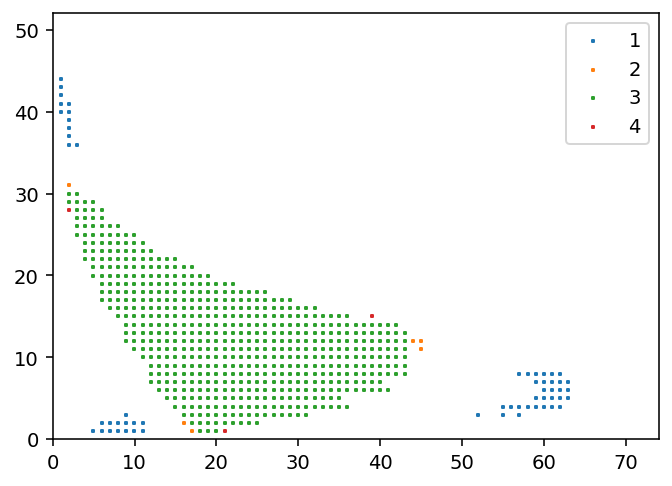

In [106]:
fig, ax = plt.subplots(dpi=141)
ax.set_xlim(xlo, xhi)
ax.set_ylim(xlo, yhi)

ax.set_aspect(1)
fig.canvas.draw()
s = max(1,((ax.get_window_extent().width  / (xhi-xlo+1.) * delta*72./fig.dpi) ** 2))  

for i in range(len(RCs)):
    
    plt.scatter((np.array(RCs[i])[:,0]-delta), (np.array(RCs[i])[:,1]-delta), s=s, marker='s', label=i+1)
plt.legend()
plt.show()

In [93]:
# H = cds.maximal_closed_subgraph()
# cds.maxsubgraph = H
# # cds.G = H

# cds.cubes = cds.convert_indices_to_cubes(list(cds.G.nodes()))
# for cube in cds.cubes:
#     cds.tuplecubes.append(tuple(cube))
# cds.index_cube_dict = {k:, cds.index_cube_dict[k] for k in list(cds.G.nodes())}
# cds.cube_ind_dict = {v: k for k, v in cds.index_cube_dict.items()}


In [116]:
RCs = cds.get_recurrent_components(includeselfedges=True)

RPcubes = {}

for i in range(0,len(RCs)):#range(0,1)
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(RCs[i])
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    Nbhd = RPcubes[i][0]
    print("Finding isolated nbhd")
    S = cds.invariantPart(Nbhd)
    M = cds.cubical_wrap(S).intersection(cds.G.nodes())
    for mstep in range(20):
        M = cds.cubical_wrap(M).intersection(cds.G.nodes())
    
    #calculate index pair
    try:
        print("Calculating index pair")
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
        #write index pairs to file for Conley index calcualtion with CHomP
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        print("Calculating homology")
        
#         proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_map.map'%(i+1)],stdout=subprocess.PIPE)
        proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
        linenum = 0
#         print(proc.stdout.readlines())
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            print("           "+line.rstrip().decode('UTF-8'))
            if line.rstrip().decode('UTF-8')[0] in ['H', '	', 'D', 'f', 'i', 'F', 'I'] and not line.rstrip().decode('UTF-8')[1] == 'O':
#             if line.rstrip().decode('UTF-8')[0:2] == 'H_' or line.rstrip().decode('UTF-8')[0:2] == '  ' or line.rstrip().decode('UTF-8')[0:2] == 'Di':
                
                print("           "+line.rstrip().decode('UTF-8'))
            linenum+=1
            
    except Exception as e:
        if e=='too many values to unpack (expected 4)':
            print('Faile')
        else:
            print(e)

Component 1
Finding isolated nbhd
Calculating index pair
Calculating homology
           HOMCUBES, ver. 3.07, 09/25/15. Copyright (C) 1997-2015 by Pawel Pilarczyk.
           This is free software. No warranty. Consult 'license.txt' for details.
           Note: The empty file 'rc1_P0_cubes.cub' is assumed to contain cubes.
           Reading cubes to X from 'rc1_P1_cubes.cub'... 742 cubes read.
           Reading cubes to A from 'rc1_P0_cubes.cub'... 0 cubes read.
           300 bit fields allocated (0 MB) to speed up 2-dimensional reduction.
           Reducing full-dim cubes from X... .               37*               3       74738 removed, 4 left.
           Transforming X into cells... 4 cells added.
           Collapsing faces in X... .. 32 removed, 4 left.
           Note: The dimension of X decreased from 2 to 0.
           Creating the chain complex of X... Done.
           Vertices used: 751 of dim 2.
           Time used so far: 0.01 sec (0.000 min).
           Computing the